In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
import sklearn.preprocessing
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense,Dropout,LSTM,GRU
from keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tabulate import tabulate
import seaborn as sns

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/CallMePo/Final-Project-PMA/master/KepRiau%202015%20-%202022.csv ')
df

,datetime,total_visitor,total_accomodation
0,1/1/2014,164430,10055
1,2/1/2014,137055,10079
2,3/1/2014,167030,10132
3,4/1/2014,151982,10190
4,5/1/2014,154299,10274
...,...,...,...
103,8/1/2022,79470,15449
104,9/1/2022,104652,15502
105,10/1/2022,106160,15525
106,11/1/2022,103940,15612


In [3]:
df.isna().sum()

datetime              0
total_visitor         0
total_accomodation    0
dtype: int64

In [4]:
train_datetime=pd.to_datetime(df['datetime'])
train_datetime

0     2014-01-01
1     2014-02-01
2     2014-03-01
3     2014-04-01
4     2014-05-01
         ...    
103   2022-08-01
104   2022-09-01
105   2022-10-01
106   2022-11-01
107   2022-12-01
Name: datetime, Length: 108, dtype: datetime64[ns]

In [5]:
selected_columns = ['total_visitor','total_accomodation']
data_train = df.loc[:, selected_columns].astype(float)

In [6]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_train)

TRAIN TEST SIZE (80:20)

In [7]:
n_future=1
n_step=12

X_train=[]
y_train=[]
for i in range (n_step, len(data_scaled)-n_future+1):
    past_data = data_scaled[i-n_step:i, 0:data_scaled.shape[1]]
    future_data=data_scaled[i+n_future - 1:i +n_future,0]
    
    X_train.append(past_data)
    y_train.append(future_data)

X_train=np.array(X_train)
y_train=np.array(y_train)
X_train, X_test, y_train, y_test=train_test_split(X_train,y_train, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(76, 12, 2)
(76, 1)
(20, 12, 2)
(20, 1)


In [8]:
model=Sequential()
model.add(LSTM(256, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               265216    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 265473 (1.01 MB)
Trainable params: 265473 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
early_stop=EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history=model.fit(X_train,y_train, epochs=100, batch_size=32,validation_split=0.2, callbacks=[early_stop])

Epoch 1/100
2/2 [==============================] - 3s 492ms/step - loss: 0.2647 - val_loss: 0.0804
Epoch 2/100
2/2 [==============================] - 0s 58ms/step - loss: 0.0891 - val_loss: 0.0440
Epoch 3/100
2/2 [==============================] - 0s 47ms/step - loss: 0.0766 - val_loss: 0.0384
Epoch 4/100
2/2 [==============================] - 0s 46ms/step - loss: 0.0634 - val_loss: 0.0126
Epoch 5/100
2/2 [==============================] - 0s 31ms/step - loss: 0.0438 - val_loss: 0.0180
Epoch 6/100
2/2 [==============================] - 0s 47ms/step - loss: 0.0458 - val_loss: 0.0250
Epoch 7/100
2/2 [==============================] - 0s 36ms/step - loss: 0.0508 - val_loss: 0.0192
Epoch 8/100
2/2 [==============================] - 0s 62ms/step - loss: 0.0421 - val_loss: 0.0099
Epoch 9/100
2/2 [==============================] - 0s 53ms/step - loss: 0.0365 - val_loss: 0.0071
Epoch 10/100
2/2 [==============================] - 0s 44ms/step - loss: 0.0354 - val_loss: 0.0076
Epoch 11/100
2/2 [

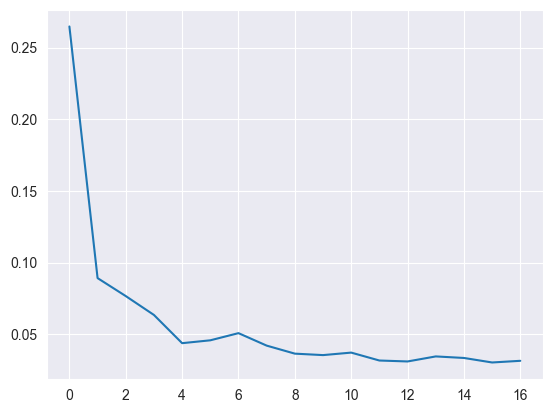

In [12]:
plt.plot(history.history['loss'])

In [13]:
n_past=1
n_pred=12
last_date=list(train_datetime)[-n_past]

predict_12=pd.date_range(last_date, periods=n_pred, freq='M').tolist()
print(predict_12)

[Timestamp('2022-12-31 00:00:00'), Timestamp('2023-01-31 00:00:00'), Timestamp('2023-02-28 00:00:00'), Timestamp('2023-03-31 00:00:00'), Timestamp('2023-04-30 00:00:00'), Timestamp('2023-05-31 00:00:00'), Timestamp('2023-06-30 00:00:00'), Timestamp('2023-07-31 00:00:00'), Timestamp('2023-08-31 00:00:00'), Timestamp('2023-09-30 00:00:00'), Timestamp('2023-10-31 00:00:00'), Timestamp('2023-11-30 00:00:00')]


In [14]:
from sklearn.metrics import mean_absolute_error

prediction=model.predict(X_test[-n_pred:])

mse=mean_squared_error(y_test[-n_pred:],prediction)
rmse=np.sqrt(mse)
mape=mean_absolute_percentage_error(y_test[-n_pred:],prediction)
mae=mean_absolute_error(y_test[-n_pred:], prediction)

print("mse:",mse)
print("rmse",rmse)
print("MAPE:", f"{mape:.2f}%")
print("mae",mae)

1/1 [==============================] - 0s 473ms/step
mse: 0.027082535140084643
rmse 0.16456772204805123
MAPE: 16.49%
mae 0.09961988554942529


In [15]:
prediction_copy = np.repeat(prediction, data_train.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copy)[:, 0]

C:\Users\atrke\AppData\Local\Temp\ipykernel_4360\1927344708.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual['datetime']=pd.to_datetime(actual['datetime'])
C:\Users\atrke\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\atrke\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\atrke\AppDa

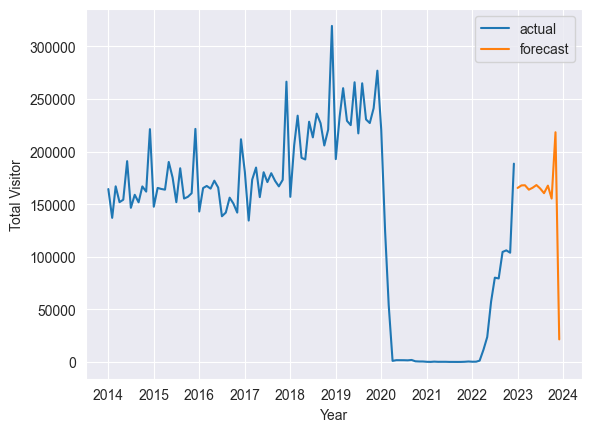

In [16]:
forecast_dates=[]
for i in predict_12:
    forecast_dates.append(i.date())
    
df_forecast=pd.DataFrame({'Date': forecast_dates,'total_visitor':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

actual=df[['datetime','total_visitor']]
actual['datetime']=pd.to_datetime(actual['datetime'])
actual=actual.loc[actual['datetime']>='2013-01-01']

sns.lineplot(actual, x='datetime', y='total_visitor',label='actual')
sns.lineplot(df_forecast,x='Date',y='total_visitor',label='forecast')

plt.xlabel('Year')
plt.ylabel('Total Visitor')
plt.legend()
plt.show()


In [17]:
forecast_dates_1=pd.date_range(start='2023-01-01', end='2023-12-01', freq='MS')

data=list(zip(forecast_dates_1,y_pred_future))

headers=['Date','Prediction']
table=tabulate(data, headers=headers, tablefmt='fancy_grid')
print(table)

╒═════════════════════╤══════════════╕
│ Date                │   Prediction │
╞═════════════════════╪══════════════╡
│ 2023-01-01 00:00:00 │     165480   │
├─────────────────────┼──────────────┤
│ 2023-02-01 00:00:00 │     167895   │
├─────────────────────┼──────────────┤
│ 2023-03-01 00:00:00 │     168022   │
├─────────────────────┼──────────────┤
│ 2023-04-01 00:00:00 │     163835   │
├─────────────────────┼──────────────┤
│ 2023-05-01 00:00:00 │     165640   │
├─────────────────────┼──────────────┤
│ 2023-06-01 00:00:00 │     168214   │
├─────────────────────┼──────────────┤
│ 2023-07-01 00:00:00 │     164960   │
├─────────────────────┼──────────────┤
│ 2023-08-01 00:00:00 │     160517   │
├─────────────────────┼──────────────┤
│ 2023-09-01 00:00:00 │     167671   │
├─────────────────────┼──────────────┤
│ 2023-10-01 00:00:00 │     155376   │
├─────────────────────┼──────────────┤
│ 2023-11-01 00:00:00 │     218403   │
├─────────────────────┼──────────────┤
│ 2023-12-01 00:00:00 │  

TRAIN TEST SIZE 70:30

In [18]:
n_future=1
n_step=12

X_train=[]
y_train=[]
for i in range (n_step, len(data_scaled)-n_future+1):
    past_data = data_scaled[i-n_step:i, 0:data_scaled.shape[1]]
    future_data=data_scaled[i+n_future - 1:i +n_future,0]

    X_train.append(past_data)
    y_train.append(future_data)

X_train=np.array(X_train)
y_train=np.array(y_train)
X_train, X_test, y_train, y_test=train_test_split(X_train,y_train, test_size=0.3, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(67, 12, 2)
(67, 1)
(29, 12, 2)
(29, 1)


In [19]:
model=Sequential()
model.add(LSTM(256, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 256)               265216    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 265473 (1.01 MB)
Trainable params: 265473 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [22]:
early_stop=EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history=model.fit(X_train,y_train, epochs=100, batch_size=32,validation_split=0.2, callbacks=[early_stop])

Epoch 1/100
2/2 [==============================] - 2s 380ms/step - loss: 0.1811 - val_loss: 0.0479
Epoch 2/100
2/2 [==============================] - 0s 42ms/step - loss: 0.0639 - val_loss: 0.0629
Epoch 3/100
2/2 [==============================] - 0s 48ms/step - loss: 0.0836 - val_loss: 0.0273
Epoch 4/100
2/2 [==============================] - 0s 57ms/step - loss: 0.0427 - val_loss: 0.0136
Epoch 5/100
2/2 [==============================] - 0s 41ms/step - loss: 0.0422 - val_loss: 0.0194
Epoch 6/100
2/2 [==============================] - 0s 42ms/step - loss: 0.0454 - val_loss: 0.0198
Epoch 7/100
2/2 [==============================] - 0s 31ms/step - loss: 0.0429 - val_loss: 0.0126
Epoch 8/100
2/2 [==============================] - 0s 42ms/step - loss: 0.0371 - val_loss: 0.0072
Epoch 9/100
2/2 [==============================] - 0s 46ms/step - loss: 0.0375 - val_loss: 0.0078
Epoch 10/100
2/2 [==============================] - 0s 48ms/step - loss: 0.0367 - val_loss: 0.0070
Epoch 11/100
2/2 [

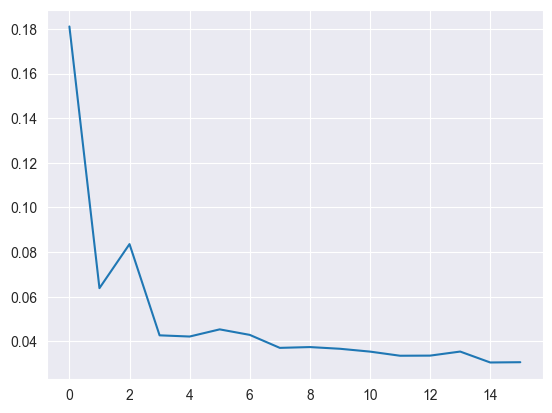

In [23]:
plt.plot(history.history['loss'])

In [24]:
n_past=1
n_pred=12
last_date=list(train_datetime)[-n_past]

predict_12=pd.date_range(last_date, periods=n_pred, freq='M').tolist()
print(predict_12)

[Timestamp('2022-12-31 00:00:00'), Timestamp('2023-01-31 00:00:00'), Timestamp('2023-02-28 00:00:00'), Timestamp('2023-03-31 00:00:00'), Timestamp('2023-04-30 00:00:00'), Timestamp('2023-05-31 00:00:00'), Timestamp('2023-06-30 00:00:00'), Timestamp('2023-07-31 00:00:00'), Timestamp('2023-08-31 00:00:00'), Timestamp('2023-09-30 00:00:00'), Timestamp('2023-10-31 00:00:00'), Timestamp('2023-11-30 00:00:00')]


In [25]:
from sklearn.metrics import mean_absolute_error

prediction=model.predict(X_test[-n_pred:])

mse=mean_squared_error(y_test[-n_pred:],prediction)
rmse=np.sqrt(mse)
mape=mean_absolute_percentage_error(y_test[-n_pred:],prediction)
mae=mean_absolute_error(y_test[-n_pred:], prediction)

print("mse:",mse)
print("rmse",rmse)
print("MAPE:", f"{mape:.2f}%")
print("mae",mae)

1/1 [==============================] - 0s 299ms/step
mse: 0.013869771588100157
rmse 0.11776999443024593
MAPE: 15.33%
mae 0.08201789808876637


In [26]:
prediction_copy = np.repeat(prediction, data_train.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copy)[:, 0]

C:\Users\atrke\AppData\Local\Temp\ipykernel_4360\1927344708.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual['datetime']=pd.to_datetime(actual['datetime'])
C:\Users\atrke\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\atrke\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\atrke\AppDa

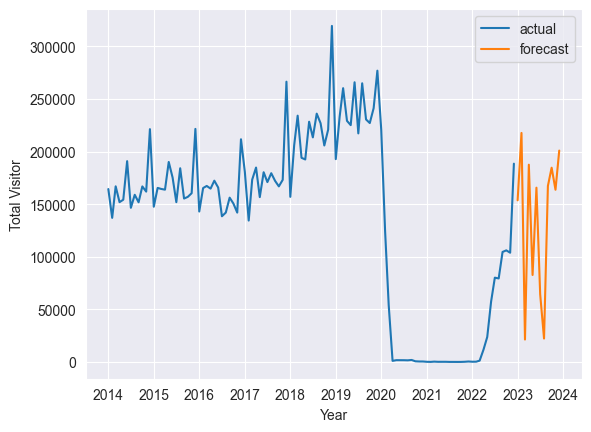

In [27]:
forecast_dates=[]
for i in predict_12:
    forecast_dates.append(i.date())
    
df_forecast=pd.DataFrame({'Date': forecast_dates,'total_visitor':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

actual=df[['datetime','total_visitor']]
actual['datetime']=pd.to_datetime(actual['datetime'])
actual=actual.loc[actual['datetime']>='2013-01-01']

sns.lineplot(actual, x='datetime', y='total_visitor',label='actual')
sns.lineplot(df_forecast,x='Date',y='total_visitor',label='forecast')

plt.xlabel('Year')
plt.ylabel('Total Visitor')
plt.legend()
plt.show()


In [28]:
forecast_dates_1=pd.date_range(start='2023-01-01', end='2023-12-01', freq='MS')

data=list(zip(forecast_dates_1,y_pred_future))

headers=['Date','Prediction']
table=tabulate(data, headers=headers, tablefmt='fancy_grid')
print(table)

╒═════════════════════╤══════════════╕
│ Date                │   Prediction │
╞═════════════════════╪══════════════╡
│ 2023-01-01 00:00:00 │     153728   │
├─────────────────────┼──────────────┤
│ 2023-02-01 00:00:00 │     217742   │
├─────────────────────┼──────────────┤
│ 2023-03-01 00:00:00 │      21435.6 │
├─────────────────────┼──────────────┤
│ 2023-04-01 00:00:00 │     187567   │
├─────────────────────┼──────────────┤
│ 2023-05-01 00:00:00 │      82768.9 │
├─────────────────────┼──────────────┤
│ 2023-06-01 00:00:00 │     165729   │
├─────────────────────┼──────────────┤
│ 2023-07-01 00:00:00 │      64458.4 │
├─────────────────────┼──────────────┤
│ 2023-08-01 00:00:00 │      22369.4 │
├─────────────────────┼──────────────┤
│ 2023-09-01 00:00:00 │     167373   │
├─────────────────────┼──────────────┤
│ 2023-10-01 00:00:00 │     184715   │
├─────────────────────┼──────────────┤
│ 2023-11-01 00:00:00 │     163779   │
├─────────────────────┼──────────────┤
│ 2023-12-01 00:00:00 │  

TRAIN TEST SIZE 60:40

In [29]:
n_future=1
n_step=12

X_train=[]
y_train=[]
for i in range (n_step, len(data_scaled)-n_future+1):
    past_data = data_scaled[i-n_step:i, 0:data_scaled.shape[1]]
    future_data=data_scaled[i+n_future - 1:i +n_future,0]

    X_train.append(past_data)
    y_train.append(future_data)

X_train=np.array(X_train)
y_train=np.array(y_train)
X_train, X_test, y_train, y_test=train_test_split(X_train,y_train, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(76, 12, 2)
(76, 1)
(20, 12, 2)
(20, 1)


In [30]:
model=Sequential()
model.add(LSTM(256, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 256)               265216    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 265473 (1.01 MB)
Trainable params: 265473 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [33]:
early_stop=EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history=model.fit(X_train,y_train, epochs=100, batch_size=32,validation_split=0.2, callbacks=[early_stop])

Epoch 1/100
2/2 [==============================] - 2s 365ms/step - loss: 0.2729 - val_loss: 0.0861
Epoch 2/100
2/2 [==============================] - 0s 53ms/step - loss: 0.0963 - val_loss: 0.0280
Epoch 3/100
2/2 [==============================] - 0s 47ms/step - loss: 0.0628 - val_loss: 0.0387
Epoch 4/100
2/2 [==============================] - 0s 46ms/step - loss: 0.0728 - val_loss: 0.0132
Epoch 5/100
2/2 [==============================] - 0s 32ms/step - loss: 0.0425 - val_loss: 0.0150
Epoch 6/100
2/2 [==============================] - 0s 47ms/step - loss: 0.0418 - val_loss: 0.0234
Epoch 7/100
2/2 [==============================] - 0s 48ms/step - loss: 0.0490 - val_loss: 0.0224
Epoch 8/100
2/2 [==============================] - 0s 47ms/step - loss: 0.0445 - val_loss: 0.0140
Epoch 9/100
2/2 [==============================] - 0s 47ms/step - loss: 0.0364 - val_loss: 0.0069
Epoch 10/100
2/2 [==============================] - 0s 57ms/step - loss: 0.0331 - val_loss: 0.0066
Epoch 11/100
2/2 [

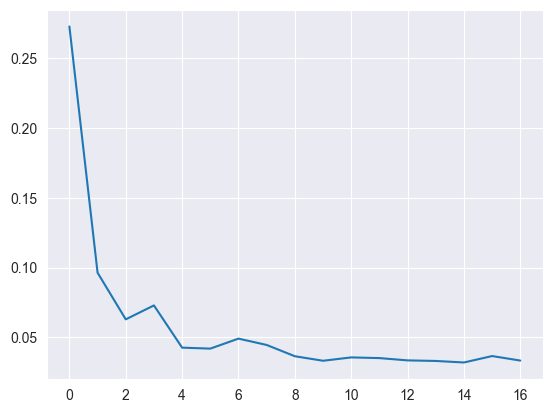

In [34]:
plt.plot(history.history['loss'])

In [35]:
n_past=1
n_pred=12
last_date=list(train_datetime)[-n_past]

predict_12=pd.date_range(last_date, periods=n_pred, freq='M').tolist()
print(predict_12)

[Timestamp('2022-12-31 00:00:00'), Timestamp('2023-01-31 00:00:00'), Timestamp('2023-02-28 00:00:00'), Timestamp('2023-03-31 00:00:00'), Timestamp('2023-04-30 00:00:00'), Timestamp('2023-05-31 00:00:00'), Timestamp('2023-06-30 00:00:00'), Timestamp('2023-07-31 00:00:00'), Timestamp('2023-08-31 00:00:00'), Timestamp('2023-09-30 00:00:00'), Timestamp('2023-10-31 00:00:00'), Timestamp('2023-11-30 00:00:00')]


In [36]:
from sklearn.metrics import mean_absolute_error

prediction=model.predict(X_test[-n_pred:])

mse=mean_squared_error(y_test[-n_pred:],prediction)
rmse=np.sqrt(mse)
mape=mean_absolute_percentage_error(y_test[-n_pred:],prediction)
mae=mean_absolute_error(y_test[-n_pred:], prediction)

print("mse:",mse)
print("rmse",rmse)
print("MAPE:", f"{mape:.2f}%")
print("mae",mae)

1/1 [==============================] - 0s 310ms/step
mse: 0.030818369595996584
rmse 0.1755516151905091
MAPE: 17.08%
mae 0.10387680072900596


In [37]:
prediction_copy = np.repeat(prediction, data_train.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copy)[:, 0]

C:\Users\atrke\AppData\Local\Temp\ipykernel_4360\1927344708.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual['datetime']=pd.to_datetime(actual['datetime'])
C:\Users\atrke\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\atrke\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\atrke\AppDa

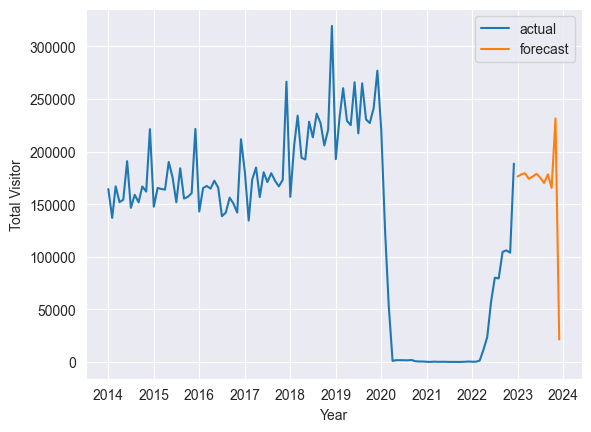

In [38]:
forecast_dates=[]
for i in predict_12:
    forecast_dates.append(i.date())
    
df_forecast=pd.DataFrame({'Date': forecast_dates,'total_visitor':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

actual=df[['datetime','total_visitor']]
actual['datetime']=pd.to_datetime(actual['datetime'])
actual=actual.loc[actual['datetime']>='2013-01-01']

sns.lineplot(actual, x='datetime', y='total_visitor',label='actual')
sns.lineplot(df_forecast,x='Date',y='total_visitor',label='forecast')

plt.xlabel('Year')
plt.ylabel('Total Visitor')
plt.legend()
plt.show()


In [39]:
forecast_dates_1=pd.date_range(start='2023-01-01', end='2023-12-01', freq='MS')

data=list(zip(forecast_dates_1,y_pred_future))

headers=['Date','Prediction']
table=tabulate(data, headers=headers, tablefmt='fancy_grid')
print(table)

╒═════════════════════╤══════════════╕
│ Date                │   Prediction │
╞═════════════════════╪══════════════╡
│ 2023-01-01 00:00:00 │     176367   │
├─────────────────────┼──────────────┤
│ 2023-02-01 00:00:00 │     178408   │
├─────────────────────┼──────────────┤
│ 2023-03-01 00:00:00 │     179416   │
├─────────────────────┼──────────────┤
│ 2023-04-01 00:00:00 │     174166   │
├─────────────────────┼──────────────┤
│ 2023-05-01 00:00:00 │     176220   │
├─────────────────────┼──────────────┤
│ 2023-06-01 00:00:00 │     178873   │
├─────────────────────┼──────────────┤
│ 2023-07-01 00:00:00 │     175364   │
├─────────────────────┼──────────────┤
│ 2023-08-01 00:00:00 │     170185   │
├─────────────────────┼──────────────┤
│ 2023-09-01 00:00:00 │     178406   │
├─────────────────────┼──────────────┤
│ 2023-10-01 00:00:00 │     165528   │
├─────────────────────┼──────────────┤
│ 2023-11-01 00:00:00 │     231552   │
├─────────────────────┼──────────────┤
│ 2023-12-01 00:00:00 │  